In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MOT_TR import MOT
from Utils import *
import os
from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
params = {
    'd':1.2,
    'thred_s':0.3,
    'N':20,
    'delta_thred' : 1e-3,
    'step':0.1,
    'win_size':(5,15),
    'eps': 1.6,
    'min_samples':20,
    'missing_thred':60,
    'ending_frame' : 17950,
    'background_update_frame':2000,
    'save_pcd' : 'Unfiltered',
    'save_Azimuth_Laser_info' : False,
    'result_type':'merged'

}

input_path = '../RawLidarData/Veteran'
dir_lis = os.listdir(input_path)
pcap_path = 'None'
for f in dir_lis:
    if 'pcap' in f.split('.'):
        pcap_path = os.path.join(input_path,f)
if pcap_path == 'None':
    print('Pcap file is not detected')
output_file_path = '../RawLidarData/Veteran'
config_path = os.path.join(input_path,'config.json')
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

mot = MOT(pcap_path,output_file_path,**params)
mot.initialization()
mot.mot_tracking(A,P,H,Q,R)

Initialization...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.97it/s]


Generating Threshold Map


Tracking 2000 frame:  11%|██████▏                                                 | 1999/17949 [03:47<33:52,  7.85it/s]

Generating Threshold Map


Tracking 4000 frame:  22%|████████████▍                                           | 3999/17949 [07:59<26:23,  8.81it/s]

Generating Threshold Map


Tracking 6000 frame:  33%|██████████████████▋                                     | 5999/17949 [11:50<21:23,  9.31it/s]

Generating Threshold Map


Tracking 8000 frame:  45%|████████████████████████▉                               | 7999/17949 [16:29<23:15,  7.13it/s]

Generating Threshold Map


Tracking 10000 frame:  56%|██████████████████████████████▋                        | 9999/17949 [21:10<20:56,  6.33it/s]

Generating Threshold Map


Tracking 12000 frame:  67%|████████████████████████████████████                  | 11999/17949 [26:28<14:09,  7.01it/s]

Generating Threshold Map


Tracking 14000 frame:  78%|██████████████████████████████████████████            | 13999/17949 [31:10<09:29,  6.93it/s]

Generating Threshold Map


Tracking 16000 frame:  89%|████████████████████████████████████████████████▏     | 15999/17949 [35:36<04:01,  8.06it/s]

Generating Threshold Map


Tracking 17949 frame: 100%|██████████████████████████████████████████████████████| 17949/17949 [39:37<00:00,  7.55it/s]


In [8]:
A = np.array([ # x,y,x',y',x'',y''
    [1,0,1,0,.5,0],
    [0,1,0,1,0,.5],
    [0,0,1,0,1,0],
    [0,0,0,1,0,1],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1]
])
H = np.array([
    [1,0,0,0,0,0],
    [0,1,0,0,0,0]
])
R = np.diag([10,10])
Q = np.diag([1,1,0.1,0.1,0.001,0.001])
P_em = np.diag([10,10,0.1,0.1,0.001,0.001])

In [9]:
ind = 3
traj_mea_ = mot.Off_tracking_pool[ind].mea_seq
traj_mea = []
for i,s in enumerate(traj_mea_):
    if type(s) != int:
        traj_mea.append(s)
traj_mea = np.array(traj_mea)
traj_post = mot.Off_tracking_pool[ind].post_seq
traj_post = np.array(traj_post)
mea_init = traj_mea[0]
n_repr = mea_init.shape[0]
n_offset_dim = A.shape[0] - mea_init.shape[1]
state_init = np.concatenate([mea_init.reshape(-1,n_repr,2,1),np.zeros((1,n_repr,n_offset_dim,1))],axis = 2)
state_cur = state_init
P_em = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)
P_init = P_em.copy()
P_cur = P_init
total_loss = 0,
his_state_pred,his_P_pred = [],[]
his_state_est,his_P_est = [],[]

for i in range(len(traj_mea)):
    mea_next = traj_mea[i]
    if type(mea_next) != int:
        state_pred,P_pred = state_predict(A,Q,state_cur,P_cur)
        total_loss += np.sum(np.abs(mea_next - state_pred[:,:,:2]))
        state_cur,P_cur = state_update(A,H,state_pred,P_pred,R,mea_next)
        his_state_pred.append(state_pred)
        his_P_pred.append(P_pred)
        his_state_est.append(state_cur)
        his_P_est.append(P_cur)
    else:
        state_cur,P_cur = state_predict(A,Q,state_cur,P_cur)
        his_state_pred.append(state_cur)
        his_P_pred.append(P_cur)
        his_state_est.append(state_cur)
        his_P_est.append(P_cur)
his_state_pred,his_P_pred = np.array(his_state_pred),np.array(his_P_pred)
his_state_est,his_P_est = np.array(his_state_est),np.array(his_P_est)

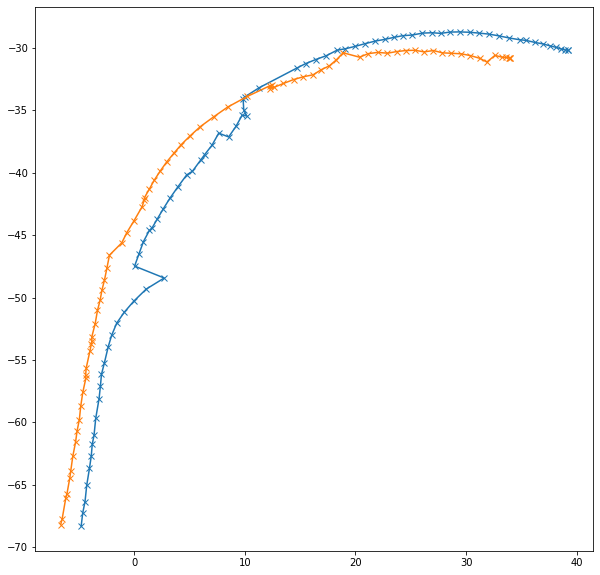

In [21]:
plt.figure(figsize = (10,10))
plt.plot(his_state_pred[:,0,0,0,0],his_state_pred[:,0,0,1,0],marker = 'x')
plt.plot(his_state_pred[:,0,1,0,0],his_state_pred[:,0,1,1,0],marker = 'x')
plt.show()
# plt.plot(traj_mea[:,0,0:],)